## Cargamos todas las bibliotecas necesarias para ejecutar todos los métodos del jupyter. 

Es buena costumbre cargarlos al principio, asi no se estar cargando en memoria repetidas veces cada paquete

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Creación de funciones auxiliares

In [2]:
def discretize(df, column):
    q1 = df_final[column].quantile(.25)
    q2 = df_final[column].quantile(.5)
    q3 = df_final[column].quantile(.75)
    df[column+"_in_q1"] = 0
    df[column+"_in_q2"] = 0
    df[column+"_in_q3"] = 0
    df[column+"_in_q4"] = 0
    df[column+"_in_q1"] = list(map(lambda x: 1 if x <=q1 else 0, df[column]))
    df[column+"_in_q2"] = list(map(lambda x: 1 if (q1 < x and x <=q2) else 0, df[column]))
    df[column+"_in_q3"] = list(map(lambda x: 1 if (q2 < x and x <=q3) else 0, df[column]))
    df[column+"_in_q4"] = list(map(lambda x: 1 if x>q3 else 0, df[column]))
    df.drop(column, axis=1, inplace=True)
    return df

In [3]:
def is_object(df,column,object_name):
    df["is_"+str(object_name)] = list(map(lambda x: 1 if x == object_name else 0, df[column]))
    return df
    

## Cargamos los datasets para construir el dataset final

In [4]:
df_first = pd.read_csv('first_part_dataset.csv')

df_second = pd.read_csv('second_part_dataset.csv')

df_thrid = pd.read_csv('thrid_part_dataset.csv')

In [5]:
df_first = df_first.rename(columns={'person_id': 'person'})

df_first = df_first.drop(columns=['Unnamed: 0'])

In [6]:
df_second.columns.values

array(['Unnamed: 0', 'person', 'diff_time_days_minnone',
       'diff_time_daysnone', 'diff_time_dayscheckout',
       'diff_time_daysconversion', 'diff_time_daysbrand listing',
       'diff_time_dayssearch engine hit', 'diff_time_start_end', 'model',
       'number_visits_model'], dtype=object)

In [7]:
df_second = df_second.drop(columns=['Unnamed: 0'])

In [8]:
df_thrid.columns.values

array(['Unnamed: 0', 'person', 'COUNT(users_logs)', 'avg_time_events'],
      dtype=object)

In [9]:
df_thrid = df_thrid.drop(columns=['Unnamed: 0'])

In [10]:
df_final = pd.merge(df_first, df_second, on='person', how='left')

df_final = pd.merge(df_final, df_thrid, on='person', how='left')

In [11]:
df_final.columns.values

array(['Android', 'BlackBerry', 'Chrome', 'Computer', 'FreeBSD', 'Linux',
       'Mac', 'Other', 'Smartphone', 'Tablet', 'Tizen', 'Ubuntu',
       'Unknown', 'Windows', 'ad campaign hit', 'brand listing',
       'checkout', 'conversion', 'generic listing', 'iOS', 'lead',
       'search engine hit', 'searched products', 'staticpage', 'target',
       'viewed product', 'visited site', 'person',
       'diff_time_days_minnone', 'diff_time_daysnone',
       'diff_time_dayscheckout', 'diff_time_daysconversion',
       'diff_time_daysbrand listing', 'diff_time_dayssearch engine hit',
       'diff_time_start_end', 'model', 'number_visits_model',
       'COUNT(users_logs)', 'avg_time_events'], dtype=object)

Significado de las columnas:

 - Las columnas 'Android', 'BlackBerry', 'Chrome', 'FreeBSD', 'Linux', 'Mac', 'Tizen', 'Ubuntu', 'Unknown', 'Windows','iOS' indican la cantidad de veces que cada usuario ingreso a la pagina de Trocafone utilizando uno de esos esos sistemas operativos. Por ejemplo, si el valor de 'Android' para un usuario es 2 siginfica que ese usuario entro a la pagina dos veces desde un dispositivo con un sistema operativo Android
 
 - Las columnas 'Computer', 'Smartphone', 'Tablet' indican la cantidad de veces que cada usuario ingreso a la pagina de Trocafone utilizando uno de esos dispositivos
 
 - Las columnas 'ad campaign hit', 'brand listing', 'checkout', 'conversion', 'generic listing', 'lead','search engine hit', 'searched products', 'staticpage','viewed product', 'visited site' indican la cantidad de veces que cada usuario realizo cada uno de esos eventos
 
 - La columna 'diff_time_days_minnone' indica la cantidad de tiempo que paso desde el primer evento que realizo el usuario hasta el 2018/06/01
 
 - La columna 'diff_time_daysnone' indica la cantidad de tiempo que paso desde el ultimo evento que el usuario realizo en la pagina hasta el 2018/06/01
 
 - La columna 'diff_time_dayscheckout' indica la cantidad de tiempo que paso desde que el usuario realizo el ultimo checkout hasta el 2018/06/01
 
 - La columna 'diff_time_daysconversion' indica la cantidad de tiempo que paso desde que el usuario realizo la ultima conversion hasta el 2018/06/01
 
 - La columna 'diff_time_daysbrand listing' indica la cantidad de tiempo que paso desde que el usuario realizo la ultima brand listing hasta el 2018/06/01
 
 - La columna 'diff_time_dayssearch engine hit' indica la cantidad de tiempo que paso desde que el usuario realizo el ultimo engine hit hasta el 2018/06/01
 
 - La columna 'diff_time_start_end' indica la cantidad de tiempo que paso entre el primer evento que realizo el usuario en la pagina y el ultimo
 
 - La columna 'model' indica el modelo de celuar que el usuario mas veces visito
 
 - La columna 'number_visits_model' indica cuantas veces el usuario visito el celular que mas visito
 
 - La columna 'COUNT(users_logs)' indica la cantidad de eventos que el usuario realizo en la pagina
 
 - La columna 'avg_time_events' indica el tiempo promedio que paso entre los eventos realizados por cada usuario

## Reemplazamos con zeros los NaNs

In [12]:
df_final.fillna(value=0,inplace=True)

### Eliminamos las columnas con muy pocas variables o alta corrleación (Ej. Windows ~ Computer)

In [13]:
df_final.drop(["BlackBerry","Chrome","FreeBSD","Linux","Mac","Other","Tizen","Ubuntu","Unknown","Windows"],
              axis=1,
              inplace=True)

### Transformamos algunas columnas para que su distribución se ajuste a una Chi cuadrado o Normal. Luego discretizamos por cuantiles

In [14]:
df_final.loc[:,"diff_time_daysnone"] = np.log10(df_final["diff_time_daysnone"]+1.)
df_final.loc[:,"diff_time_days_minnone"] = np.log10(df_final.diff_time_days_minnone+1.)
df_final.loc[:,"diff_time_dayssearch engine hit"] = np.log10(df_final["diff_time_dayssearch engine hit"]+1.0)
df_final.loc[:,"COUNT(users_logs)"] = np.log10(df_final["COUNT(users_logs)"]+1.)
df_final.loc[:,"number_visits_model"] = np.log10(1.+df_final.number_visits_model)
df_final.loc[:,"diff_time_daysbrand listing"] = np.log10(01.+df_final["diff_time_daysbrand listing"])

In [15]:
for column in ["diff_time_days_minnone","diff_time_dayssearch engine hit","COUNT(users_logs)","number_visits_model","diff_time_daysbrand listing","diff_time_daysnone"]:
    df_final = discretize(df_final,column)
    

### La columna `model` contiene una concatenación de `marca `+` modelo`. 

Separando esta columna podemos detectar qué marcas son las más populares y qué modelos (dentro de cada marca) son los más buscados

In [16]:
df_final["marca"] = df_final.model.str.split(" ",1,expand=True)[0]
df_final["modelo"] = df_final.model.str.split(" ",1,expand=True)[1]

In [17]:
df_final["marca"].value_counts()

iPhone      8017
Samsung     7663
Motorola    2257
LG           301
Lenovo       146
Sony         108
iPad          36
Asus          31
Quantum       11
Name: marca, dtype: int64

In [18]:
df_final["modelo"].value_counts()

6                               1752
5s                              1639
6S                              1361
Galaxy J5                       1022
7                                703
7 Plus                           613
Galaxy S8                        609
Galaxy S7                        604
Galaxy S7 Edge                   603
Galaxy J7 Prime                  489
Moto G2 3G Dual                  404
Galaxy S6 Edge                   393
Galaxy S6 Flat                   386
5c                               352
6S Plus                          344
Galaxy J7                        337
6 Plus                           337
Moto G4 Plus                     313
SE                               311
Galaxy Gran Prime Duos TV        245
4S                               232
Galaxy S8 Plus                   230
5                                223
Moto G3 4G                       191
Galaxy A5 2017                   185
Moto X Play 4G Dual              174
Moto G5 Plus                     169
G

In [19]:
df_final["is_iphone"] = list(map(lambda x: 1 if x=="iPhone" else 0, df_final["marca"]))
df_final["is_samsung"] = list(map(lambda x: 1 if x=="Samsung" else 0, df_final["marca"]))
df_final["is_motorola"] = list(map(lambda x: 1 if x=="Motorola" else 0, df_final["marca"]))
df_final["is_lg"] = list(map(lambda x: 1 if x=="LG" else 0, df_final["marca"]))
df_final["is_sony"] = list(map(lambda x: 1 if x=="Sony" else 0, df_final["marca"]))
df_final["is_other"] = list(map(lambda x: 1 if (x!="Sony" and x!="LG" and x!="Motorola" and x!="Samsung" and x!="iPhone") else 0, df_final["marca"]))


In [20]:
pop_models = ['6','5s','6S','Galaxy J5','7','7 Plus','Galaxy S8','Galaxy S7','Galaxy S7 Edge','Galaxy J7 Prime','Moto G2 3G Dual','Galaxy S6 Edge','Galaxy S6 Flat','5c','6S Plus','Galaxy J7','6 Plus','Moto G4 Plus','SE','Galaxy Gran Prime Duos TV','4S','Galaxy S8 Plus','5','Moto G3 4G','Galaxy A5 2017','Moto X Play 4G Dual','Moto G5 Plus','Galaxy A7 2017','Moto X2','Galaxy A5']

In [21]:
for model in pop_models:
    df_final = is_object(df_final,"modelo",model)

In [22]:
df_final["is_other_model"] = list(map(lambda x: 1 if x not in pop_models else 0, df_final["modelo"]))

### Eliminamos las columnas que contienen strings, previamente preprocesadas

In [23]:
df_final.drop(["model","person","marca","modelo"],axis=1,inplace=True)

### Analizamos la distribución de categorías en el dataset crudo

In [24]:
df_final['target'].value_counts()

0.0    18434
1.0      980
Name: target, dtype: int64

### Vamos a seleccionar solo 980 casos que no realizaron una compra para balancear el dataset

In [25]:
df_train = df_final[df_final['target']==1]

print(len(df_train.index))

980


In [26]:
df_final_reduced_0 = df_final[df_final['target']==0].sample(n=980, random_state=1)

print(len(df_final_reduced_0.index))

980


In [27]:
df_train = pd.concat([df_train, df_final_reduced_0])

del df_final_reduced_0

### Nos quedamos con aquellas columnas que no sean target

In [28]:
feature_columns = list(set(df_train.columns.tolist())-set(["target"]))

### Obtenemos el dataset de test y lo eliminamos del dataset de train

In [29]:
df_test = df_train.sample(frac=0.2, random_state=2)
df_train.drop(df_test.index,axis=0,inplace=True)

### Verificamos el balance de categorías en cada datset

In [30]:
N_train = df_train.shape[0]*1.
N_test = df_test.shape[0]*1.

N_train_1 = df_train.target.sum()
N_train_0 = df_train.shape[0]*1.-N_train_1

N_test_1 = df_test.target.sum()
N_test_0 = df_test.shape[0]*1.-N_test_1

In [31]:
print("Porcentaje de casos positivos en el train: %" + str(100.0*N_train_1/N_train))
print("Porcentaje de casos positivos en el test: %" + str(100.0*N_test_1/N_test))

Porcentaje de casos positivos en el train: %50.255102040816325
Porcentaje de casos positivos en el test: %48.97959183673469


## Utilizando únicamente el dataset de train ejecutamos 5-fold Cross Validation

In [32]:
scoring = ['accuracy','roc_auc']

In [44]:
dtree = DecisionTreeClassifier(max_depth=3, criterion='entropy') 

In [45]:
scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                        df_train[feature_columns].values, # X_train features
                        df_train["target"].values, # Y_train targets
                        scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                        return_train_score = True, # Queremos ver los scorings de los training folds
                        return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                        cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                        n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                       )



### Cargamos los resultados en un DF de Pandas

In [46]:
cv_5_fold_resultados = pd.DataFrame(scores)

In [47]:
cv_5_fold_resultados.drop(["fit_time","score_time","estimator"],axis=1,inplace=True)

In [48]:
cv_5_fold_resultados

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.786624,0.765550,0.821750,0.831958
1,0.767516,0.764753,0.852686,0.826109
2,0.710191,0.784689,0.746734,0.844177
3,0.760383,0.772112,0.814572,0.829870
4,0.769968,0.768924,0.809713,0.834916


### Calculamos los estadisticos de cada experimento, tanto para train como para test

In [49]:
cv_5_fold_resultados.describe()

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
count,5.000000,5.000000,5.000000,5.000000
mean,0.758937,0.771206,0.809091,0.833406
std,0.028897,0.008085,0.038664,0.006822
min,0.710191,0.764753,0.746734,0.826109
25%,0.760383,0.765550,0.809713,0.829870
50%,0.767516,0.768924,0.814572,0.831958
75%,0.769968,0.772112,0.821750,0.834916
max,0.786624,0.784689,0.852686,0.844177


### Seleccionamos el árbol que mejor accuracy haya tenido durante el train

In [50]:
best_dtree_index = np.argmax(scores["test_accuracy"])

In [51]:
best_btree = scores["estimator"][best_dtree_index]

### Evaluamos su accuracy sobre el 20% restante del dataset que no formó parte del 5-fold CV

In [52]:
y_esperado = df_test.target.values
y_pred = best_btree.predict(df_test[feature_columns].values)

In [53]:
print("Score validation: " + str(accuracy_score(y_esperado, y_pred)))

Score validation: 0.7857142857142857


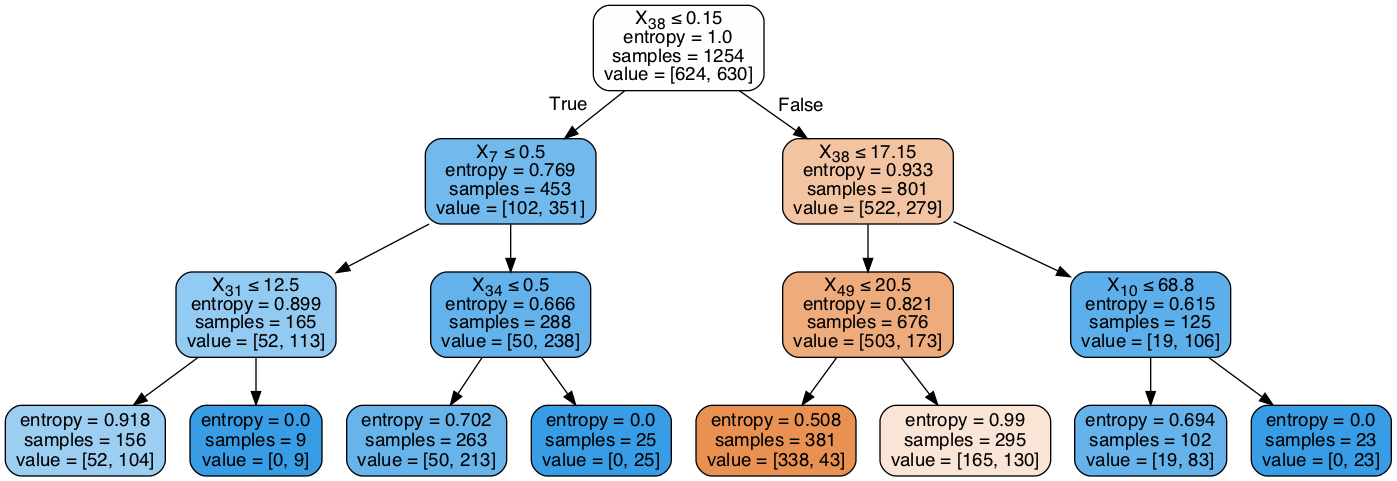

In [54]:
dot_data = StringIO()
export_graphviz(best_btree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Obtenemos el dataset de "work", a partir del cual vamos a obtener el dataset de training y el de validacion

In [ ]:
df_work = df_final_reduced.loc[~df_final_reduced.index.isin(df_test.index)]

print(len(df_work.index))

In [ ]:
df_work = df_work.sample(frac=1).reset_index(drop=True)

In [ ]:
print(len(df_work.index))

df_work.head(3)

### Sacamos columnas que no son numericas

In [ ]:
df_work = df_work.drop(columns=['person', 'model', 'marca', 'modelo'])

### Agregamos una columna al dataset que indica a que fold pertenece

In [ ]:
def generate_number_fold(dataframe, number_folds):
    
    number_rows = len(dataframe.index)
    
    rows_per_fold = round(number_rows/number_folds)
    
    array_number_folds = []
    
    index = 1
    
    while index < (number_folds + 1):
        
        if (number_folds - index) == 1:
            
            array_numbers = [index] * (number_rows - rows_per_fold*index)
        
            array_number_folds = array_number_folds + array_numbers
            
        else:
            
            array_numbers = [index] * rows_per_fold

            array_number_folds = array_number_folds + array_numbers
            
        index = index + 1

    dataframe['folds'] = array_number_folds
    
    return dataframe
        

### Filtramos por los folds que generamos con generate_number_fold() y vamos calculando las metricas que necesitamos tanto para training como para validation

In [ ]:
def applied_cross_validation_dt(dataframe, number_folds, depth, criterion):
    
    df_folds = generate_number_fold(dataframe, number_folds)
    
    index = 1
    
    array_accuracy_training = []
    
    array_accuracy_val = []
    
    array_auc_training = []
    
    array_auc_val = []
    
    while index < (number_folds + 1):
        
        df_specific_fold = df_folds[df_folds['folds']==index].drop(columns=['folds'])
        
        X = df_specific_fold.drop(columns=['target'])

        y = df_specific_fold['target']
        
        train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=123)
        
        dtree=DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        
        dtree.fit(train_X, train_y)
        
        predictions_val = dtree.predict(test_X)
        predictions_train = dtree.predict(train_X)
        
        proba_val = dtree.predict_proba(test_X)
        proba_train = dtree.predict_proba(train_X)
        
        acc_val = accuracy_score(test_y, predictions_val)
        acc_train = accuracy_score(train_y, predictions_train)
        
        auc_val = roc_auc_score(test_y, proba_val[:,1])
        auc_train = roc_auc_score(train_y, proba_train[:,1])
        
        array_accuracy_val.append(acc_val)
        
        array_accuracy_training.append(acc_train)
        
        array_auc_training.append(auc_val)
    
        array_auc_val.append(auc_train)
        
        index = index + 1
    
    return array_accuracy_training, array_accuracy_val, array_auc_training, array_auc_val

In [ ]:
applied_cross_validation_dt(df_work, 5, 3, 'gini')

In [ ]:
def generate_table(acc_train, acc_val, auc_train, auc_val, criterion, depth, number_folds):
    
    d = {'acc_train': acc_train, 'acc_val': acc_val, 'auc_train': auc_train, 'auc_val': auc_val}
    
    df = pd.DataFrame(data=d)
    
    df['criterion'] = [criterion] * number_folds
    
    df['max_depth'] = [depth] * number_folds
    
    return df

In [ ]:
acc_train_gini = applied_cross_validation_dt(df_work, 5, 3, 'gini')[0]

acc_val_gini = applied_cross_validation_dt(df_work, 5, 3, 'gini')[1]

auc_train_gini = applied_cross_validation_dt(df_work, 5, 3, 'gini')[2]

auc_val_gini = applied_cross_validation_dt(df_work, 5, 3, 'gini')[3]

df_gini_3 = generate_table(acc_train_gini, acc_val_gini, auc_train_gini, auc_val_gini, 'Gini', 3, 5)

df_gini_3 = df_gini_3.append(df_gini_3.mean(numeric_only=True), ignore_index=True)

df_gini_3

In [ ]:
def highlight_total_row(s):
    if s.B > 1.0:
        return ['background-color: yellow']*5
 
df.style.apply(highlight_greaterthan_1, axis=1)

In [ ]:
acc_train_gini = applied_cross_validation_dt(df_work, 5, 6, 'gini')[0]

acc_val_gini = applied_cross_validation_dt(df_work, 5, 6, 'gini')[1]

auc_train_gini = applied_cross_validation_dt(df_work, 5, 6, 'gini')[2]

auc_val_gini = applied_cross_validation_dt(df_work, 5, 6, 'gini')[3]

generate_table(acc_train_gini, acc_val_gini, auc_train_gini, auc_val_gini, 'Gini', 6, 5)